In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import umap

In [2]:
tidy_data = pd.read_csv('vitalsing_data.csv').sample(n=4000, random_state=369)

X_data = tidy_data.drop(['ID','CHT_NO', 'admin_date', 'discharge_date',
                         'AllMortality', 'CVDeath  ', 'Death Date', 'SurvivalWeeks'], axis=1)
y_data = tidy_data[['SurvivalWeeks']]
y_data = (y_data < 24).astype(int)

categorical_ix = [0, 2, 3, 4, 5, 6, 7, 8]
categorical_columns = X_data.columns[categorical_ix].values
numerical_columns =  np.setdiff1d(X_data.columns, categorical_columns)

In [3]:
print(X_data.head())
print(categorical_columns)
print(numerical_columns)

       Sex   Age   AF   DM  HTN  Dyslipidemia  CHF  Smoking  \
10008  0.0  71.0  0.0  0.0  0.0           0.0  0.0      0.0   
10543  1.0  72.0  0.0  1.0  1.0           1.0  0.0      1.0   
1258   1.0  42.0  0.0  0.0  1.0           0.0  0.0      1.0   
2016   1.0  46.0  0.0  1.0  1.0           0.0  0.0      1.0   
8769   1.0  66.0  0.0  1.0  1.0           1.0  0.0      0.0   

       Cancer before adm    E  ...  DBP SD  DBPSD G  DBP CV  DBPCV G  Mean RR  \
10008                0.0  4.0  ...     9.0      3.0    0.09      3.0     17.9   
10543                0.0  4.0  ...    11.3      3.0    0.11      3.0     17.4   
1258                 0.0  4.0  ...     9.0      3.0    0.08      3.0     17.9   
2016                 0.0  3.0  ...     8.8      3.0    0.10      3.0     18.0   
8769                 0.0  4.0  ...     9.6      3.0    0.10      3.0     17.5   

       MeanRR G  RR SD  RRSD G  RR CV  RRCV G  
10008       3.0    1.3     2.0   0.07     2.0  
10543       3.0    1.2     2.0   0.07 

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_data[numerical_columns] = StandardScaler().fit_transform(X_data[numerical_columns])
# one-hot
X_data_one_hot = pd.get_dummies(X_data, columns=categorical_columns)
print(X_data.head())

       Sex       Age   AF   DM  HTN  Dyslipidemia  CHF  Smoking  \
10008  0.0  0.348662  0.0  0.0  0.0           0.0  0.0      0.0   
10543  1.0  0.427044  0.0  1.0  1.0           1.0  0.0      1.0   
1258   1.0 -1.924413  0.0  0.0  1.0           0.0  0.0      1.0   
2016   1.0 -1.610885  0.0  1.0  1.0           0.0  0.0      1.0   
8769   1.0 -0.043247  0.0  1.0  1.0           1.0  0.0      0.0   

       Cancer before adm         E  ...    DBP SD  DBPSD G    DBP CV  \
10008                0.0  0.197486  ... -0.100791  0.24032 -0.547164   
10543                0.0  0.197486  ...  0.716338  0.24032  0.015762   
1258                 0.0  0.197486  ... -0.100791  0.24032 -0.828627   
2016                 0.0 -2.271086  ... -0.171846  0.24032 -0.265701   
8769                 0.0  0.197486  ...  0.112373  0.24032 -0.265701   

        DBPCV G   Mean RR  MeanRR G     RR SD    RRSD G     RR CV    RRCV G  
10008 -0.245766  0.264639 -0.045314 -0.125818  0.164398 -0.232606 -0.522584  
10543 -0

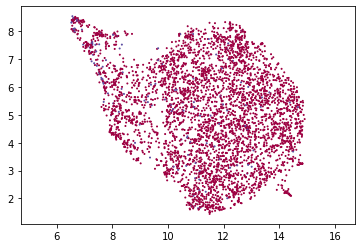

In [5]:
reducer = umap.UMAP(random_state=369)
umap_embedding = reducer.fit_transform(X_data_one_hot)

plt.clf()
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')

C:\Users\USER\anaconda3\envs\reStroke\lib\site-packages\umap\umap_.py:1728: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


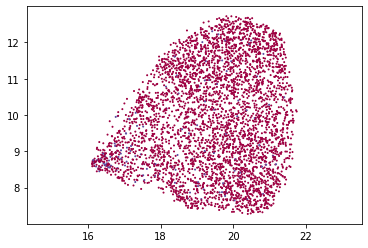

In [7]:
import distython

heom_metric = distython.HEOM(X_data, categorical_ix)
reducer = umap.UMAP(metric=heom_metric.heom, random_state=369 , n_neighbors=50)
umap_heom_embedding = reducer.fit_transform(X_data)

plt.clf()
plt.scatter(
    umap_heom_embedding[:, 0],
    umap_heom_embedding[:, 1],
    c=y_data.values.astype(int), s=1, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')